# 1. Introduction

According to the spatial distribution of two extreme precipitation indices, i.e., R95p and R50, Nie and Sun (2021) regionalize the southwest China (SWC) into two subregions. This division of SWC is based on both the terrain in the southwest China and the k-means clustering analysis.
    
    
In this post, we try to reproduce the clustering of R95p in  Nie and Sun (2021) (**Figure 1**).

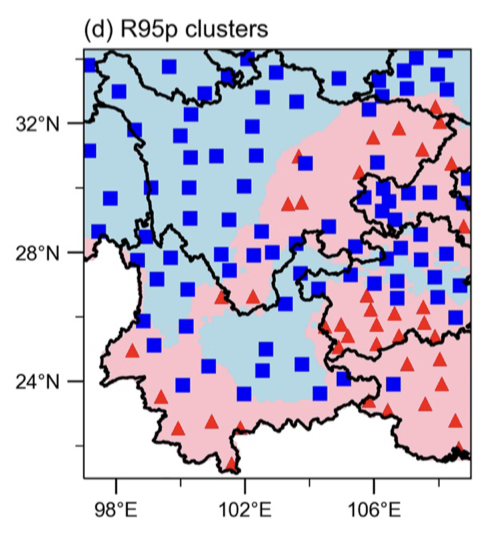
> <center> <b>Figure 1.</b> Figure 1d in Nie and Sun (2021). </center>

# 2. Data and Method

* **Precipitation data:** In Nie and Sun (2021), the observational gauge precipitation data used from the National Meteorological Information Center of the China Meteorological Administration and the Integrated Multi-Satellite Retrievals for Global Precipitation Measurement (GPM) mission (IMERG) (Hou et al., 2014) precipitation data (0.1° × 0.1°, daily) are used. However, I only get access to the GPM-IMERG, which is used in this post.
    
    
* **Definition of R95p indice:** The total precipitation when the daily precipitation exceeds the 95th percentile of precipitation in May–September
    
    
* **An excellent guide of k-means clustering analysis:** https://www.dominodatalab.com/blog/getting-started-with-k-means-clustering-in-python#using-scikit

# 3. Calculate the R95p based on GPM-IMEGR precipitation data  
The time range of GPM-IMEGR precipitation data in Nie and Sun (2021) is from 1978 to 2018, but we just use the data from 2001 to 2019 in this post.

In [1]:
import os 
import xarray as xr
import numpy as np
from scipy import stats
import netCDF4 as nc

'''Specific year of data: 2001-2019, Apr-Sep'''
time_ls = []
for year in range(2001, 2020):
    for mon in range(4, 10):
        time = str(year) + str(mon).rjust(2,'0')    #set the format 01, 02, 03...
        time_ls.append(time)
        print(time)
        print('--------------------------------------------------')
        
        
'''Read GPM data'''
precip_all = []
for each in time_ls:
    filename = '3B-HHR.MS.MRG.3IMERG.' + each + '.daily.V06B.nc'
    filepath = '/data1/GPM/datasets/daily/'
    precip_data = xr.open_dataset(filepath + filename)
    precip = np.asarray(precip_data.precipitationCal.loc[:,21:34.3,97:109])[:,::-1,:] # 97°–109°E, 21°–34.3°N
    precip_all.append(precip)
    print(each)
    print(precip[:,0,0])
    print('--------------------------------------------------')
latitude = precip_data.lat.loc[21:34.3][::-1]
longitude = precip_data.lon.loc[97:109]


'''Calculate R95p'''
precips_3D = np.concatenate(precip_all, axis=0)  #Dimension: (n*time,lat,lon)
print(precips_3D[0,:,:])
time_number = precips_3D.shape[0]
lat_number = precips_3D.shape[1]
lon_number = precips_3D.shape[2]
sum_grid = np.zeros((lat_number, lon_number))   #Store the sum of every grid, i.e., R95p
for lat in range(lat_number):
    for lon in range(lon_number):
        peR95p = stats.scoreatpercentile(precips_3D[:,lat,lon], 95)
        sum_grid[lat, lon] = sum(precips_3D[:,lat,lon][precips_3D[:,lat,lon]>peR95p])

        
'''Save R95p in NC file'''
print(sum_grid[:,0])
f_w = nc.Dataset('./R95p.nc','w',format = 'NETCDF4')   

f_w.createDimension('lat', sum_grid.shape[0])   
f_w.createDimension('lon', sum_grid.shape[1])  

lat = f_w.createVariable('lat', np.float64, ('lat'))  
lon = f_w.createVariable('lon', np.float64, ('lon'))
R95p = f_w.createVariable('R95p', np.float64, ('lat','lon'))

lat.units = 'degree'
lon.units = 'degree'
R95p.units = 'mm'

f_w.variables['lat'][:] = latitude
f_w.variables['lon'][:] = longitude
f_w.variables['R95p'][:,:] = sum_grid

f_w.close()

# 3. Classify precipitation in SWC via K-means clustering depending on R95p

In [2]:
import xarray as xr
import numpy as np
import os
import math
from scipy import ndimage
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import MultipleLocator 
import matplotlib.dates as mdates
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point
import cartopy.io.shapereader as shpreader
from pylab import *
import time
import datetime
from scipy import interpolate
from skimage import transform
from scipy import stats

## Step 1 Read the R95p data

In [3]:
R95p_data = xr.open_dataset('./R95p.nc')
print(R95p_data)
R95p = np.asarray(R95p_data.R95p)
longitude = np.asarray(R95p_data.lon)
latitude = np.asarray(R95p_data.lat)

<xarray.Dataset>
Dimensions:  (lat: 133, lon: 120)
Coordinates:
  * lat      (lat) float64 34.25 34.15 34.05 33.95 ... 21.35 21.25 21.15 21.05
  * lon      (lon) float64 97.05 97.15 97.25 97.35 ... 108.7 108.8 108.8 108.9
Data variables:
    R95p     (lat, lon) float64 ...


## Step 2 Mask the points out of SWC
Before clustering the preicpitation over SWC, the grid points out of the SWC should be ruled out.
    
    
**Reference of mask in python:** https://gis.stackexchange.com/questions/354782/masking-netcdf-time-series-data-from-shapefile-using-python

In [4]:
'''Function of mask by employing shp-file'''
from osgeo import gdal,osr,ogr
def makeMask(lon,lat,res,shapefile):
    source_ds = ogr.Open(shapefile)
    source_layer = source_ds.GetLayer()
 
    # Create high res raster in memory
    mem_ds = gdal.GetDriverByName('MEM').Create('', lon.size, lat.size, gdal.GDT_Byte)
    mem_ds.SetGeoTransform((lon.min(), res, 0, lat.max(), 0, -res)) # The latitude should be sorted in descending order
    band = mem_ds.GetRasterBand(1)
 
    # Rasterize shapefile to grid
    gdal.RasterizeLayer(mem_ds, [1], source_layer, burn_values=[1])
 
    # Get rasterized shapefile as numpy array
    array = band.ReadAsArray()
 
    # Flush memory file
    mem_ds = None
    band = None
    return array

Warning 1: Failed to fetch spatial reference on layer 地理信息图层_省界 to build transformer, assuming matching coordinate systems.


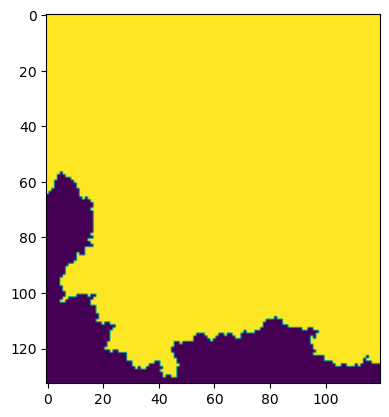

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


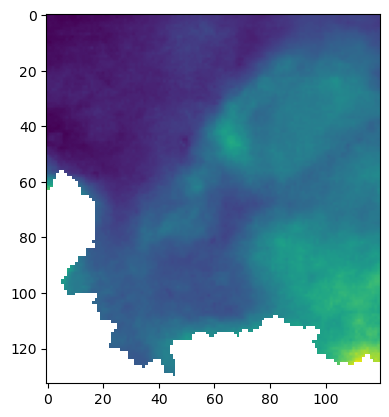

--
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


In [5]:
'''Mask the points out of SWC'''
###Show the mask###
shapefile = '/Users/harvey/Desktop/Personal Data/Python File/Shp/China_shp/地理信息图层_省界.shp'  #shp-file of China
cellsize = longitude[:][1] - longitude[:][0]
china_mask = makeMask(longitude,latitude,cellsize,shapefile)
plt.imshow(china_mask)
plt.show()
print(china_mask)

###Mask the unnecessary points in R95p###
R95p_mask = np.ma.masked_where(china_mask==0, R95p) #Mask the data out of SWC (i.e., china_mask==0)
plt.imshow(R95p_mask)
plt.show()
print(R95p_mask[-1][-1])
print(R95p_mask.mask)

> <center> <b>Figure 2.</b> Schematic of the mask. </center>

## Step 3 K-means clustering

In [6]:
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.utils import shuffle

To confirm whether the data matrix of R95p is masked correctly, a comparison is made between the masked R95p matrix and the unmasked R95p matrix. 

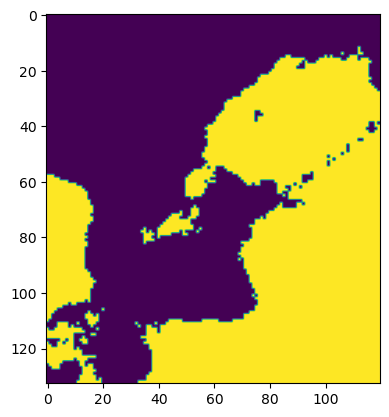

In [7]:
'''K-means clustering by R95p'''
R95p_samples = np.reshape(R95p, (R95p.shape[0]*R95p.shape[1],1))
model = KMeans(n_clusters=2) 
R95p_kmeans = model.fit(R95p_samples)
R95p_labels = np.reshape(R95p_kmeans.labels_, R95p.shape)
plt.imshow(R95p_labels)
plt.show()

> <center> <b>Figure 3.</b> Schematic of the clusters without mask. </center>

The schematic of clustering with mask.

R95p_labels.shape: (13520,)


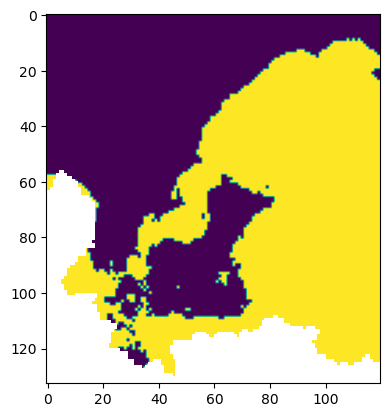

In [8]:
'''K-means clustering by R95p_mask'''
R95p_samples = np.reshape(R95p_mask[R95p_mask.mask==False], 
                         (R95p_mask[R95p_mask.mask==False].shape[0],1)) #Only cluster the unmasked data (i.e., mask==False)
model = KMeans(n_clusters=2) 
R95p_kmeans = model.fit(R95p_samples)
R95p_labels = R95p_kmeans.labels_
print('R95p_labels.shape:', R95p_labels.shape)
'''Map the labels to the 1-D points in 2-D SWC region'''
rows, columns = np.where(R95p_mask.mask==False)
SWC_labels = R95p_mask.copy()
for i in range(R95p_labels.shape[0]):
    row = rows[i]
    column = columns[i]
    SWC_labels[row, column] = R95p_labels[i]
plt.imshow(SWC_labels)
plt.show()   

> <center> <b>Figure 4.</b> Schematic of the clusters with mask. </center>

## Step 4 Visualize the K-means clustering of R95p in SWC

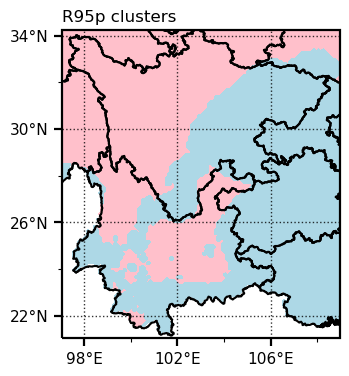

In [9]:
fig = plt.figure(figsize=(6,4), dpi=100)
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
'''底图绘制'''
shp_province = shpreader.Reader(shapefile)
ax.add_geometries(shp_province.geometries(), crs=ccrs.PlateCarree(), facecolor='none',edgecolor='k',linewidth=1.5)
'''经纬度虚线设置'''
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1,
                  linestyle=':', color='k', alpha=0.8)  #设置经纬度虚线
dlon, dlat = 4, 4
xticks = np.arange(2, 162, dlon)
yticks = np.arange(2, 42, dlat)     #如此设置才可有0度线
gl.xlocator = mticker.FixedLocator(xticks) 
gl.ylocator = mticker.FixedLocator(yticks)
'''坐标轴设置成经纬度格式'''
#####这里不需要设置major_locator，因为上部分gridlines已经完成这部分工作#####
##x轴##
ax.set_xticks(xticks, crs=ccrs.PlateCarree()) 
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))    #将数字设置为经度格式
ax.xaxis.set_minor_locator(MultipleLocator(2))     #设置经度次格距为10的倍数
##y轴##
ax.set_yticks(yticks, crs=ccrs.PlateCarree()) 
ax.yaxis.set_major_formatter(LatitudeFormatter())   #将数字设置为纬度格式
ax.yaxis.set_minor_locator(MultipleLocator(2))      #设置纬度次格距为5的倍数
'''contourf 作图'''
ax_c = ax.contourf(longitude, latitude, SWC_labels,levels=[0,0.5,1], colors=['#FFC0CB','#ADD8E6'])
# This is the fix for the white lines between contour levels
for c in ax_c.collections:
    c.set_edgecolor("face")
'''优化图片边框、坐标轴粗细''' 
ax.spines['geo'].set_linewidth('1.6')    #地图加粗边框与普通的plt不一样
ax.tick_params(axis='both', which='major', width=1.6, length=6)   #加粗主坐标轴刻度线粗细、长度
ax.tick_params(axis='both', which='minor', width=0.8, length=3)
'''name the sequence'''
ax.set_title('R95p clusters', loc='left')
ax.tick_params(labelsize=11)    #fontsize
plt.savefig('./R95p.pdf', bbox_inches='tight')
plt.show()

> <center> <b>Figure 5.</b> Reproduction of the Figure 1d in Nie and Sun (2021). </center>